### Model Starter Document
- First resize image shapes to get data
- Next get blananced dataset across all defect types for training
- Test against balanced dataset and non-balanced dataset for testing
- KNN first and then if time NN

In [1]:
# Import Plotting Libaries
# from mpl_toolkits.mplot3d import Axes3D
# import tkinter
import matplotlib.pyplot as plt # plotting
# %matplotlib inline
# plt.style.use('ggplot')
from matplotlib import colors
# from matplotlib import gridspec
#from matplotlib.ticker import StrMethodFormatter
#from matplotlib.ticker import MultipleLocator

# Import modeling libraries.
import sklearn as sk
sklearn.__version__
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from skimage.transform import resize as sk_resize

!pip install tensorflow
import tensorflow as tf

import keras
from keras import layers, Input, models, datasets, losses
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

# Import Standard Libaries
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# !pip3 install pandas_profiling
# import pandas_profiling
# from pandas_profiling import ProfileReport

!pip3 install pickle5
import pickle5 as pickle
import time

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

--------------------------
### Data Prep

In [2]:
# import pickle5 as pickle
with open('WM-clean.pkl', "rb") as fh:
    data = pickle.load(fh)


In [3]:
data.head()

,waferMap,dieSize,lotName,waferIndex,failureType,encoding,x_,y_,shape,labels,dataset
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train


In [4]:
# profile = ProfileReport(data, minimal=True)
# profile.to_file("profile_report_output.html")

In [5]:
# add classification model labels
fail_types = data.failureType.unique()
fail_dict = {fail_types[i]:i for i in range(len(fail_types))}
print(fail_dict)

data['classify_labels'] = data['failureType'].apply(lambda x: fail_dict[x])
data.head()

{'none': 0, 'Loc': 1, 'Edge-Loc': 2, 'Center': 3, 'Edge-Ring': 4, 'Scratch': 5, 'Random': 6, 'Near-full': 7, 'Donut': 8}


,waferMap,dieSize,lotName,waferIndex,failureType,encoding,x_,y_,shape,labels,dataset,classify_labels
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,0


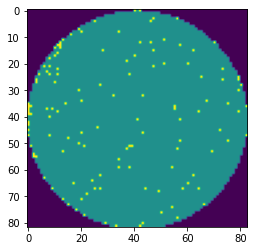

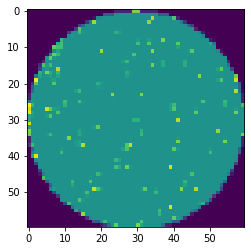

In [6]:
# example
#set resize dim variable - will use later
x_dim = 60
y_dim = 60

d12 = data[data['lotName'] == 'lot15471'].iloc[0].waferMap
d123 = sk_resize(d12*1024,[x_dim,y_dim], anti_aliasing=True)
plt.imshow(d12);
plt.show()
plt.imshow(d123);
plt.show()

In [7]:
# Build function to resize images
def resize_wafers(row):
    base_map = row['waferMap']
    resize_map = sk_resize(base_map*1024,[x_dim,y_dim], anti_aliasing=True)
    return resize_map

data['resize_waferMap'] = data.apply (lambda row: resize_wafers(row), axis=1)


In [8]:
# Add single label for model building

def label_wafer (row):
    string = ""
    if row['labels'][0] == 1:
        string += 'N'
    if row['labels'][1] == 1:
        string += 'ER'
    if row['labels'][2] == 1:
        string += 'EL'
    if row['labels'][3] == 1:
        string += 'C'
    if row['labels'][4] == 1:
        string += 'L'
    if row['labels'][5] == 1:
        string += 'S'
    if row['labels'][6] == 1:
        string += 'R'
    if row['labels'][7] == 1:
        string += 'D'
    if row['labels'][8] == 1:
        string += 'NF'
    if string == "":
        string = 'N'
    return string

def flat_map (row, map):
    return row[map].flatten()


# data['wafer_label'] = data.apply (lambda row: label_wafer(row), axis=1)
# data['flat_waferMap'] = data.apply (lambda row: flat_map(row, 'waferMap'), axis=1)
data['fr_waferMap'] = data.apply (lambda row: flat_map(row, 'resize_waferMap'), axis=1)
data.head()


,waferMap,dieSize,lotName,waferIndex,failureType,encoding,x_,y_,shape,labels,dataset,classify_labels,resize_waferMap,fr_waferMap
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [9]:
# pandas_profiling.ProfileReport(data)

In [10]:
# Check out train, dev and test data sets
print(data.groupby('dataset').size().sort_values(ascending=False))

dataset
train    121065
test      25943
dev       25942
dtype: int64


In [11]:
# Check out by wafer_label
print(data.groupby('failureType').size().sort_values(ascending=False))

failureType
none         147431
Edge-Ring      9680
Edge-Loc       5189
Center         4294
Loc            3593
Scratch        1193
Random          866
Donut           555
Near-full       149
dtype: int64


In [12]:
# Remove the "None" for testing
defect_df = data[data.failureType != 'none']
print(defect_df.groupby('failureType').size().sort_values(ascending=False))

failureType
Edge-Ring    9680
Edge-Loc     5189
Center       4294
Loc          3593
Scratch      1193
Random        866
Donut         555
Near-full     149
dtype: int64


In [13]:
# Build out test, train, dev datasets and labels for defect_df
test_data     = np.stack(defect_df.loc[defect_df['dataset'] == 'test']['fr_waferMap'].to_numpy())
test_labels   = defect_df.loc[defect_df['dataset'] == 'test']['failureType'].to_numpy()
dev_data      = np.stack(defect_df.loc[defect_df['dataset'] == 'dev']['fr_waferMap'].to_numpy())
dev_labels    = defect_df.loc[defect_df['dataset'] == 'dev']['failureType'].to_numpy()
train_data    = np.stack(defect_df.loc[defect_df['dataset'] == 'train']['fr_waferMap'].to_numpy())
train_labels  = defect_df.loc[defect_df['dataset'] == 'train']['failureType'].to_numpy()

test_data_3d  = np.stack(defect_df.loc[defect_df['dataset'] == 'test']['resize_waferMap'].to_numpy())
dev_data_3d   = np.stack(defect_df.loc[defect_df['dataset'] == 'dev']['resize_waferMap'].to_numpy())
train_data_3d = np.stack(defect_df.loc[defect_df['dataset'] == 'train']['resize_waferMap'].to_numpy())

test_labels_3d   = defect_df.loc[defect_df['dataset'] == 'test']['classify_labels'].to_numpy()
dev_labels_3d    = defect_df.loc[defect_df['dataset'] == 'dev']['classify_labels'].to_numpy()
train_labels_3d  = defect_df.loc[defect_df['dataset'] == 'train']['classify_labels'].to_numpy()

test_data_3d  = tf.expand_dims(test_data_3d, axis=3, name=None)
dev_data_3d   = tf.expand_dims(dev_data_3d, axis=3, name=None)
train_data_3d = tf.expand_dims(train_data_3d, axis=3, name=None)
train_data_3d.shape


TensorShape([17863, 60, 60, 1])

In [14]:
# test_data = np.stack(test_data)
print('data shape: ', test_data.shape)
print('data 0 shape: ', test_data[0].shape)
print('label shape:', test_labels.shape)
print(type(test_data))
print(type(test_data[0]))
print(test_data[0])


data shape:  (3828, 3600)
data 0 shape:  (3600,)
label shape: (3828,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[0. 0. 0. ... 0. 0. 0.]


['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch']


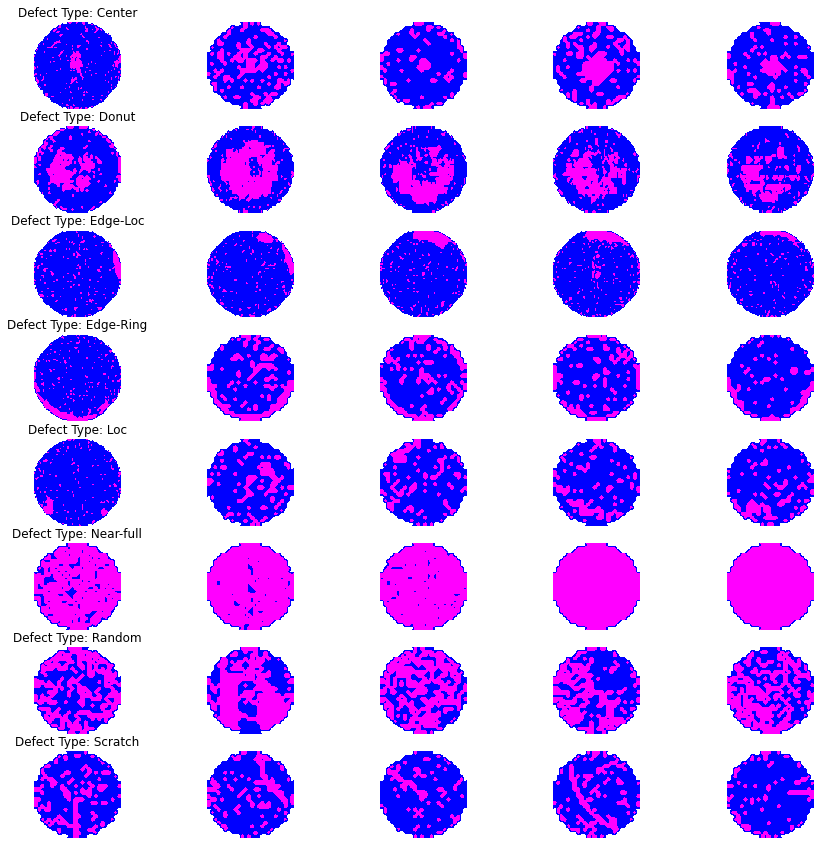

In [15]:
def show_wafermaps_types(num_examples=10):
    # Find unique digits, will be 0-9
    examples = np.unique(train_labels)
    print(examples)
    # Find the square dimentions of the X array for shaping for 2D Rendering, will be 28
#     dim = int(np.sqrt(mini_train_data.shape[1]))
#     dim=(25,27)
    dim=(x_dim, y_dim)

    # Set to Black and White
    # make a color map of fixed colors - blue passing die, yellow failing die
    cmap = colors.ListedColormap(['white', 'blue', 'fuchsia'])
    plt.rc('image', cmap=cmap)

    # Setup Figure Size and number of sub plots, examples sent into function and number of digits
    fig, axs = plt.subplots(len(examples), num_examples, figsize=(15, 15))

    # Nested for loops to loop through all digits and number of examples input for ploting
    for i,d in enumerate(examples):
        for j in range(num_examples):
            # reshape as 2D for rendering from dimensions above
            # imshow to plot image in axs i,j loaction in plot
            axs[i,j].imshow(train_data[train_labels==d][j].reshape(dim))
            axs[i,j].axis('off')

            if j == 0:
                axs[i, j].set_title(f'Defect Type: {d}')
            
show_wafermaps_types(5)

------------------------------------------------------------------------------
### Simple KNN Model


               precision    recall  f1-score   support

      Center       0.79      0.96      0.87       670
       Donut       0.79      0.74      0.76        76
    Edge-Loc       0.85      0.76      0.80       786
   Edge-Ring       0.95      0.99      0.97      1434
         Loc       0.64      0.53      0.58       509
   Near-full       0.94      1.00      0.97        29
      Random       0.96      0.72      0.82       148
     Scratch       0.38      0.40      0.39       176

    accuracy                           0.83      3828
   macro avg       0.79      0.76      0.77      3828
weighted avg       0.83      0.83      0.83      3828



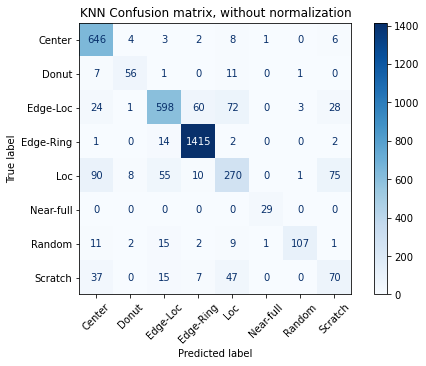

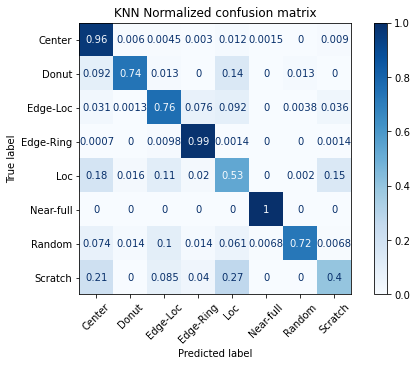

 total: 3828  correct: 3191  accuracy: 83.36%


In [16]:
def KNN_model():

    # Find unique wafer patterns
    elements = np.unique(train_labels)
    
    # Build Model and Confusion Matrix
    model = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
    model.fit(train_data, train_labels)
    predicted_labels = model.predict(test_data)
    correct_prediction = (predicted_labels == test_labels)
    wrong_prediction = (predicted_labels != test_labels)
    model_score = model.score(test_data, test_labels)
    cm = confusion_matrix(test_labels, predicted_labels, labels=model.classes_)
    
    print('\n', classification_report(test_labels, predicted_labels))
    
    # Plot Confusion matrix and find top misclassifications 
    titles_options = [("KNN Confusion matrix, without normalization", None),
                  ("KNN Normalized confusion matrix", 'true')]

    for title, normalize in titles_options:
        disp = plot_confusion_matrix(model, test_data, test_labels,
                                     display_labels= elements,
                                     cmap=plt.cm.Blues,
                                     normalize=normalize)
        disp.ax_.set_title(title)
        fig = plt.gcf()
        fig.set_size_inches(8,5)
        plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees


    plt.show()
    
    # Evaluate and show the accuracy of each model.
    print (' total: %3d  correct: %3d  accuracy: %.2f%%' 
           %((np.sum(correct_prediction)+np.sum(wrong_prediction)), 
              np.sum(correct_prediction), model_score*100))   
    

KNN_model()

------------------------------------------------------------------------------
### Try MLP (Multilayer Perceptron) Model

              precision    recall  f1-score   support

      Center       0.93      0.95      0.94       670
       Donut       0.75      0.82      0.78        76
    Edge-Loc       0.78      0.81      0.80       786
   Edge-Ring       0.95      0.98      0.97      1434
         Loc       0.63      0.69      0.66       509
   Near-full       0.82      0.93      0.87        29
      Random       0.70      0.84      0.77       148
     Scratch       1.00      0.02      0.04       176

    accuracy                           0.85      3828
   macro avg       0.82      0.76      0.73      3828
weighted avg       0.86      0.85      0.83      3828



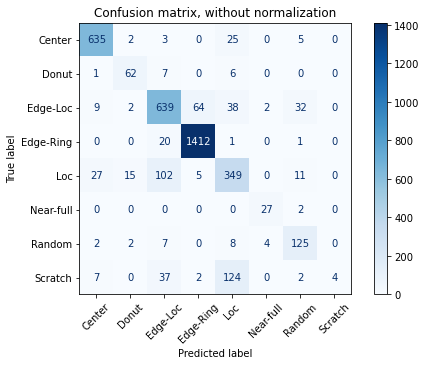

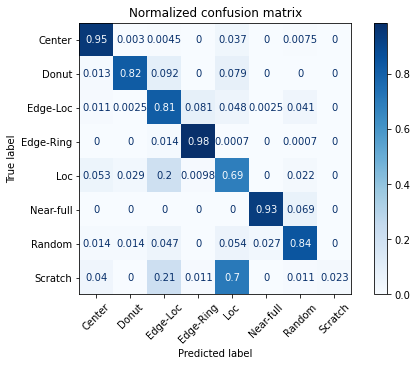

Overall accuracy: 84.9791013584117%


In [31]:
## Create current best classifier
hidden_layer_sizes = tuple([100]*10)

# build classifier with Best Parameters
# Best parameters =  {'activation': 'tanh', 'learning_rate': 'adaptive', 'solver': 'adam'}

classifier = MLPClassifier(hidden_layer_sizes = hidden_layer_sizes, 
                           #activation = 'relu', 
                           activation = 'tanh',
                           learning_rate = 'adaptive',
                           solver = 'adam',
                           early_stopping = True, alpha = 0.0001)

# fit classifier to training data
classifier.fit(train_data, train_labels)

# make predictions of test data
predictions = classifier.predict(test_data)

# Find unique wafer patterns
elements = np.unique(train_labels)

# generate and print classification report
print(classification_report(test_labels, predictions))

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, test_data, test_labels,
                                 display_labels= elements,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    fig = plt.gcf()
    fig.set_size_inches(8,5)
    plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees


plt.show()

# calculate and print accuracy
print("Overall accuracy: " + 
      str(100*metrics.accuracy_score(test_labels, predictions)) + "%")

In [18]:
## Use grid search to evaluate parameters

# choose variables for grid search
parameters = {"activation": ["identity", "logistic", "tanh", "relu"],
              "solver": ["sgd","adam"],
              "learning_rate": ["constant", "adaptive"]}

# build classifier
classifier = GridSearchCV(MLPClassifier(hidden_layer_sizes = hidden_layer_sizes,
                                        early_stopping = True), 
                          param_grid = parameters, cv = 10, 
                          scoring = "accuracy")

# fit classifier to training data
classifier.fit(train_data, train_labels)

# make predictions of test data
predictions = classifier.predict(test_data)

C:\Users\scott\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\scott\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [19]:
print("Best parameters = ", classifier.best_params_)

# calculate and print accuracy
print("Best accuracy: " + 
      str(100*metrics.accuracy_score(test_labels, predictions)) + "%")

Best parameters =  {'activation': 'tanh', 'learning_rate': 'adaptive', 'solver': 'adam'}
Best accuracy: 85.21421107628004%


In [20]:
## Use manual loop to evaluate parameters

# for activation in parameters["activation"]:
    
#     # build classifier
#     classifier = MLPClassifier(hidden_layer_sizes = hidden_layer_sizes,
#                                early_stopping = True, activation = activation)

#     # fit classifier to training data
#     classifier.fit(train_data, train_labels)

#     # make predictions of test data
#     predictions = classifier.predict(test_data)

#     print("Activation: " + activation)
#     # calculate and print accuracy
#     print("Accuracy: " + 
#       str(100*metrics.accuracy_score(test_labels, predictions)) + "%")

### Week 6 Update
#### What we've accomplished
- Run preliminary models

|Model             | Data used                | Run time | Accuracy | Precision | Recall | F1   |
|------------------|--------------------------|----------|----------|-----------|--------|------|
|KNN Filter        | 516 die size             | Fast     | 0.97     | 0.34      | 0.28   | 0.25 |
|Simple NN	Filter | 516 die size             | Fast     | 0.97     | 0.12      | 0.12   | 0.12 |
|Knn	           | All die - 'none' removed | Slow     | 0.83     | 0.77      | 0.78   | 0.77 |
|Simple NN	       | All die - 'none' removed | Slow     | 0.84     | 0.69      | 0.73   | 0.71 |

- Built function to resize images to account for different die sizes
- Found issues with model
    - Class imbalance impacting results (high rate of none or no defect pattern)
    - Issues with accuracy
    
#### Next Steps
- Model Enhancement Next Steps (flow)
    - First pass filter to remove baseline failure noise
    - First pass classification into defect pattern or none - benefits are faster and removes major class imbalance
    - Improve on model for defect pattern detection (continue search on alternative models)
- Determine interactive grouping features for user interface
- Potential look at multi-class defect pattern classification (stretch target)


Best parameters =  {'activation': 'relu'}
Best accuracy: 84.79623824451411%

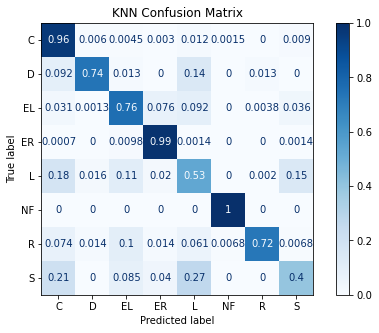
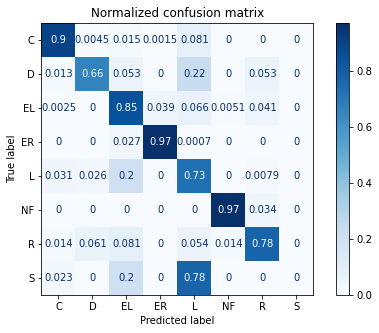

--------------------------
### Tensor Flow NN

In [21]:
epoch=5
batch_size=1024

In [22]:
def create_model():
    
    input_shape=train_data_3d.shape[1:]
    #input_shape = (x_dim, y_dim, 1)
    #input_shape = (x_dim * y_dim)
    input_tensor = Input(input_shape)

    conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
    conv_2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv_1)
    conv_3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv_2)

    flat = layers.Flatten()(conv_3)

    dense_1 = layers.Dense(512, activation='relu')(flat)
    dense_2 = layers.Dense(128, activation='relu')(dense_1)
    output_tensor = layers.Dense(9, activation='softmax')(dense_2)

    model = models.Model(input_tensor, output_tensor)
    model.compile(optimizer='Adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

In [23]:
# one hot encode target values
train_data_3d = to_categorical(train_data_3d)
dev_data_3d = to_categorical(dev_data_3d)
test_data_3d = to_categorical(test_data_3d)

In [24]:
NN_model = models.Sequential()
NN_model.add(layers.Conv2D(6, 5, activation='tanh', input_shape=train_data_3d.shape[1:]))
NN_model.add(layers.AveragePooling2D(2))
NN_model.add(layers.Activation('sigmoid'))
NN_model.add(layers.Conv2D(16, 5, activation='tanh'))
NN_model.add(layers.AveragePooling2D(2))
NN_model.add(layers.Activation('sigmoid'))
NN_model.add(layers.Conv2D(120, 5, activation='tanh'))
NN_model.add(layers.Flatten())
NN_model.add(layers.Dense(84, activation='tanh'))
NN_model.add(layers.Dense(10, activation='softmax'))
NN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 56, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 28, 28, 6)        0         
 ooling2D)                                                       
                                                                 
 activation (Activation)     (None, 28, 28, 6)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 12, 12, 16)       0         
 ePooling2D)                                                     
                                                                 
 activation_1 (Activation)   (None, 12, 12, 16)        0

In [25]:
NN_model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [26]:
history = NN_model.fit(train_data_3d, train_labels_3d, batch_size=64, 
                       epochs=5, validation_data=(dev_data_3d, dev_labels_3d))

Epoch 1/5
280/280 [==============================] - 25s 88ms/step - loss: 1.6830 - accuracy: 0.3759 - val_loss: 1.6269 - val_accuracy: 0.3843
Epoch 2/5
280/280 [==============================] - 25s 88ms/step - loss: 1.6456 - accuracy: 0.3793 - val_loss: 1.6256 - val_accuracy: 0.3843
Epoch 3/5
280/280 [==============================] - 25s 89ms/step - loss: 1.6454 - accuracy: 0.3793 - val_loss: 1.6263 - val_accuracy: 0.3843
Epoch 4/5
280/280 [==============================] - 25s 90ms/step - loss: 1.6449 - accuracy: 0.3793 - val_loss: 1.6265 - val_accuracy: 0.3843
Epoch 5/5
280/280 [==============================] - 25s 91ms/step - loss: 1.6445 - accuracy: 0.3793 - val_loss: 1.6300 - val_accuracy: 0.3843


In [27]:
NN_predictions = NN_model.predict(test_data_3d)

In [28]:
NN_predictions

array([[9.52e-06, 1.39e-01, 2.22e-01, ..., 5.29e-03, 3.36e-02, 1.01e-05],
       [9.52e-06, 1.39e-01, 2.22e-01, ..., 5.29e-03, 3.36e-02, 1.01e-05],
       [9.52e-06, 1.39e-01, 2.22e-01, ..., 5.29e-03, 3.36e-02, 1.01e-05],
       ...,
       [9.52e-06, 1.39e-01, 2.22e-01, ..., 5.29e-03, 3.36e-02, 1.01e-05],
       [9.52e-06, 1.39e-01, 2.22e-01, ..., 5.29e-03, 3.36e-02, 1.01e-05],
       [9.52e-06, 1.39e-01, 2.22e-01, ..., 5.29e-03, 3.36e-02, 1.01e-05]],
      dtype=float32)

In [29]:
NN_Model = KerasClassifier(build_fn=create_model, epochs=epoch, batch_size=1024, verbose=2) 
# 3-Fold Crossvalidation
kfold = KFold(n_splits=3, shuffle=True, random_state=2019) 
results = cross_val_score(NN_Model, train_data_3d, train_labels_3d, cv=kfold)
# Check 3-fold model's mean accuracy
print('Simple CNN Cross validation score : {:.4f}'.format(np.mean(results)))

C:\Users\scott\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


Epoch 1/5


C:\Users\scott\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\scott\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\scott\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py", line 236, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "C:\Users\scott\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py", line 164, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\scott\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\scott\Anaconda3\lib\site-packages\tensorflow\python\framework\func_graph.py", line 1147, in 

Epoch 1/5
Epoch 1/5
Simple CNN Cross validation score : nan


In [30]:
history = NN_Model.fit(train_data_3d, train_labels_3d,
         validation_data=[test_data_3d, test_labels_3d],
         epochs=epoch,
         batch_size=batch_size,
         )

Epoch 1/5


ValueError: in user code:

    File "C:\Users\scott\Anaconda3\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\scott\Anaconda3\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\scott\Anaconda3\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\scott\Anaconda3\lib\site-packages\keras\engine\training.py", line 860, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\scott\Anaconda3\lib\site-packages\keras\engine\training.py", line 919, in compute_loss
        y, y_pred, sample_weight, regularization_losses=self.losses)
    File "C:\Users\scott\Anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\scott\Anaconda3\lib\site-packages\keras\losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\scott\Anaconda3\lib\site-packages\keras\losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\scott\Anaconda3\lib\site-packages\keras\losses.py", line 1790, in categorical_crossentropy
        y_true, y_pred, from_logits=from_logits, axis=axis)
    File "C:\Users\scott\Anaconda3\lib\site-packages\keras\backend.py", line 5083, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 8) and (None, 9) are incompatible


In [ ]:
# make predictions of test data
NN_predictions = NN_Model.predict(test_data)

In [ ]:
# generate and print classification report

# Find unique wafer patterns
elements = np.unique(train_labels)

print(classification_report(test_labels, NN_predictions))

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(NN_Model, test_data, test_labels,
                                 display_labels= elements,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    fig = plt.gcf()
    fig.set_size_inches(8,5)

plt.show()

# calculate and print accuracy
print("Overall accuracy: " + 
      str(100*metrics.accuracy_score(test_labels, predictions)) + "%")